# Capstone project 1: Pet Product Subcategorization by Review Analysis (preprocessing)

**Problem and Goal:**  
Now, an e-commerce company has a Pet Supplies category on the website. The category has many products for dogs, cats, birds and other animals. They would like to **subcategorize them into some small subcategories** so that they can improve analysis of trends and customer needs to a specific field and their customers can easily find out a product they want.

## Table of Contents

In this preprocessing jupyter notebook:  
1. Load Data  
2. Data Wrangling  
3. Exploratory Data Analysis  

In the clustering jupyter notebook:  
4. Clustering  
5. Summary

## 1. Load Data

The animal product review dataset was acquired from AWS. This dataset contains customer reviews about the pet products from 1995 to 2015 with accompanying metadata such as the marketplace, product ID, product name, product category, star rating, review, date, etc.  

The dataset is available on https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Pet_Products_v1_00.tsv.gz    
  
Let's load the data and check the general informarion.

In [1]:
# Import the packages
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import csv

sns.set(context='notebook', style='ticks', palette='hls')
cmap1 = plt.get_cmap('Set2') 

In [2]:
# You can see this notebook without codes
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code on/off."></form>''')

In [3]:
# Load the tsv file with columns which will be used
data = pd.read_table('amazon_reviews_us_Pet_Products_v1_00.tsv', usecols=[0,4,5,6,13,14])

# Change the clomun label from 'product_parent' to 'product_id'
data = data.rename(columns={'product_parent':'product_id'})

print('data (first 5 rows):')
data.head()

data (first 5 rows):


,marketplace,product_id,product_title,product_category,review_body,review_date
0,US,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,Best belly bands on the market! These are a g...,2015-08-31
1,US,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,I have been purchasing these for a long time. ...,2015-08-31
3,US,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,Worked really well. Very pleased with my purc...,2015-08-31


The general informarion:

In [4]:
# Check the general information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2639981 entries, 0 to 2639980
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   marketplace       object
 1   product_id        int64 
 2   product_title     object
 3   product_category  object
 4   review_body       object
 5   review_date       object
dtypes: int64(1), object(5)
memory usage: 120.8+ MB


The presence of missing data:

In [5]:
# Any missing date?: 
data.isnull().any(axis=0)

marketplace         False
product_id          False
product_title        True
product_category    False
review_body          True
review_date          True
dtype: bool

Three columns ("product_title", "review_body", "review_date") have missing data.  

## 2. Data Wrangling

In this project, I focused on the data collected during 2014 - 2015 in the US.  
  
The purpuse of this section is to make the data ready for clustering.  The necessary data are extracted, and the reviews are divided into the tokens in the following steps.

#### Approach:

- Extract the necessary rows and columns, and deal with the missing and duplicate data:  
2.1. Extract data collected in 2014 or 2015  
2.2. Remove columns having a single value  
2.3. Deal with missing values and duplicate data  

- Collect a moderate amount of fitted reviews:   
2.4. Remove short and long reviews    
2.5. Adjust the number of reviews per product  

- Clean the tokens:  
2.6. Tokenization  
2.7. Retain only alphabets  
2.8. Remove stop words  
2.9. Stemming and lemmatization  
2.10. Retain only nouns  
2.11. Remove insignificant words

### 2.1. Extract data collected in 2014 or 2015

I've decided to use the latest two years data because I'd like to have the information of the currently popular products.

In [6]:
# Extract data in 2014 and 2015 (ignore data without a date label)
df_2015 = data[data['review_date'].str.contains('2015-', na=False)] 
df_2014 = data[data['review_date'].str.contains('2014-', na=False)] 

# Merge the two dataframes
df_two_years = df_2015.append(df_2014)

print("df_two_years (first 5 rows):")
df_two_years.head()

df_two_years (first 5 rows):


,marketplace,product_id,product_title,product_category,review_body,review_date
0,US,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,Best belly bands on the market! These are a g...,2015-08-31
1,US,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,I have been purchasing these for a long time. ...,2015-08-31
3,US,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,Worked really well. Very pleased with my purc...,2015-08-31


In [7]:
# Count the number of the rows
print('Number of rows:', len(df_two_years))

Number of rows: 1705229


### 2.2. Remove columns having a single value

All 'marketlace' values should be 'US', and all 'product_category' values should be 'Pet Products'. We don't need the columns to categorize a product. First, let's check if the columns have a single value.

In [8]:
print("Unique values of 'marketplace':", df_two_years['marketplace'].unique())
print("Unique values of 'product_category':", df_two_years['product_category'].unique())

Unique values of 'marketplace': ['US']
Unique values of 'product_category': ['Pet Products']


There is no incorrect value. Let's remove the columns and 'review_date' column that is no longer needed.

In [9]:
# Remove the three columns
df = df_two_years[['product_id', 'product_title', 'review_body']]

print("df (first 5 rows):")
df.head()

df (first 5 rows):


,product_id,product_title,review_body
0,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Best belly bands on the market! These are a g...
1,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,"My dogs love Hugs and Kisses. However, the la..."
2,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,I have been purchasing these for a long time. ...
3,568880110,"Soft Side Pet Crate, Navy/Tan","It is extremely well constructed, it is easy t..."
4,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Worked really well. Very pleased with my purc...


### 2.3. Deal with missing values and duplicate data

Let's take care of missing data and duplicate data. 

#### 2.3.1. Remove missing values

Number of missing data on each column:

In [10]:
# Number of missing date
print(df.isnull().sum())

product_id         0
product_title      0
review_body      216
dtype: int64


If droping the rows having null, how many products will be removed?

In [11]:
# Drop the rows having missing data
df_dropna = df.dropna(how='any')
print(df['product_id'].nunique() - df_dropna['product_id'].nunique(), 'products')
print(round((df['product_id'].nunique() - df_dropna['product_id'].nunique())/df['product_id'].nunique()*100,4), '%')

18 products
0.014 %


I have decided to purely remove these products from the data because the rate is very low and products without any review are not very active.  

#### 2.3.2. Remove duplicate data

Number of dulicate data:

In [12]:
# Remove duplicate data
df_drop_dup = df_dropna.drop_duplicates()
print(len(df) - len(df_drop_dup), 'reviews')

8004 reviews


They have been removed. Check the current numbers of reviews and products. 

In [13]:
# Show the number of reviews in df_drop_dup
print('Number of reviews:', len(df_drop_dup))

# Show the number of products in df_drop_dup
print('Number of products:', df_drop_dup['product_id'].nunique())

Number of reviews: 1697225
Number of products: 128977


### 2.4. Remove short and long reviews

To categorize the products, we need enough information about the product from the reviews. Short reviews may not have enough information, and also too long reviews provide too much information and make the clustering complicated. First, take a look at the statistics of the number of characters per review.

Number of character per review:

In [14]:
# Count the number of characters in each review
review_length = df_drop_dup['review_body'].str.len()

# Show the summary statistics
review_length.describe(percentiles=[0.25, 0.50, 0.75, 0.95])

count    1.697225e+06
mean     2.336816e+02
std      3.471153e+02
min      1.000000e+00
25%      5.900000e+01
50%      1.360000e+02
75%      2.810000e+02
95%      7.600000e+02
max      4.439900e+04
Name: review_body, dtype: float64

The shortest review has only one character, and the longest one has 44,399 characters! Let's plot them and see the distribution.

<IPython.core.display.Javascript object>


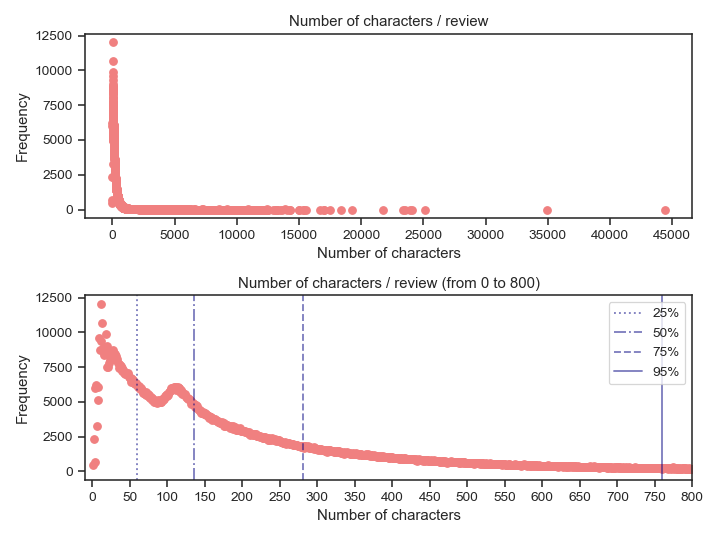

In [15]:
# Create a count plot
length_counter = Counter(review_length)

plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.scatter(length_counter.keys(), length_counter.values(), c='lightcoral')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 45000 + 1, 5000))
plt.title('Number of characters / review')

plt.subplot(2,1,2)
plt.scatter(length_counter.keys(), length_counter.values(), c='lightcoral')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.xlim([-10,800])
plt.xticks(np.arange(0, 800 + 1, 50))
plt.axvline(x=59, ymin=0, ymax=12500, c='navy', alpha=0.5, label='25%', ls=':')
plt.axvline(x=136, ymin=0, ymax=12500, c='navy', alpha=0.5, label='50%', ls='-.')
plt.axvline(x=281, ymin=0, ymax=12500, c='navy', alpha=0.5, label='75%', ls='--')
plt.axvline(x=760, ymin=0, ymax=12500, c='navy', alpha=0.5, label='95%', ls='-')
plt.title('Number of characters / review (from 0 to 800)')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

First, let's deal with very long reviews. 75% of the reviews has less than 281 characters. I think 281 characters are enough as information to get the features and subcategorize the product.  Let's get the first 281 characters if a review is loger than that.

In [16]:
# Separate long reviews
df_less281_chara = df_drop_dup.query('review_body.str.len() <= 281')
df_more281_chara = df_drop_dup.query('review_body.str.len() > 281')

# Remove the characters more than 281 
for i in range(len(df_more281_chara)):
    # culumn_2 is 'review_body'
    df_more281_chara.iat[i, 2] = df_more281_chara.iat[i, 2][:281]

# Reunion the reviews and sort by the index
df_less281_chara = df_less281_chara.append(df_more281_chara).sort_index()

print("df_less281_chara (first 5 rows):")
df_less281_chara.head()

df_less281_chara (first 5 rows):


,product_id,product_title,review_body
0,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Best belly bands on the market! These are a g...
1,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,"My dogs love Hugs and Kisses. However, the la..."
2,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,I have been purchasing these for a long time. ...
3,568880110,"Soft Side Pet Crate, Navy/Tan","It is extremely well constructed, it is easy t..."
4,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Worked really well. Very pleased with my purc...


Check the maximum number of characters per review:

In [17]:
print(max(df_less281_chara['review_body'].str.len()), 'characters')

281 characters


The longer reviews have been shortened!  
Next, let's think about short reviews. Let me say 30 characters as the minimum. Let's remove reviews having less than 30 characters.

In [18]:
# Remove reviews having less than 30 characters
df_more30_chara = df_less281_chara.query('review_body.str.len() >= 30')

print("df_more30_chara (first 5 rows):")
df_more30_chara.head()

df_more30_chara (first 5 rows):


,product_id,product_title,review_body
0,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Best belly bands on the market! These are a g...
1,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,"My dogs love Hugs and Kisses. However, the la..."
2,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,I have been purchasing these for a long time. ...
3,568880110,"Soft Side Pet Crate, Navy/Tan","It is extremely well constructed, it is easy t..."
4,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Worked really well. Very pleased with my purc...


Check the minimum number of characters per review:

In [19]:
print(min(df_more30_chara['review_body'].str.len()), 'characters')

30 characters


The short reviews have been removed.  Because of this action, some products might have been removed.  
How many products have been removed?

In [20]:
# Count the number of removed products
number_less30 = df_less281_chara['product_id'].nunique() - df_more30_chara['product_id'].nunique()

print(number_less30, 'products')
print(round(number_less30/df_less281_chara['product_id'].nunique()*100,2), '%')

9780 products
7.58 %


We lost 7.58% of the products in the data. I think that's fine because these products have only short reviews and that would mean they are less popular. Check the current numbers of reviews and products.

In [21]:
print('Number of reviews:', len(df_more30_chara))
print('Number of products:', df_more30_chara['product_id'].nunique())

Number of reviews: 1480993
Number of products: 119197


### 2.5. Adjust the number of reviews per product

We thought about the number of characters per review at 2.4. Here, let's think about the number of reviews per product. 
Some products are very popular and have a lot of reviews. On the other hand, some products are not so popular and have a few reviews. If we use all reviews, some products have a lot of tokens, but some have a few. This difference will increase in complexity of clustering. Here, let's adjust the number of reviews per product so that each product has exact ten reviews. 

First, let's check the distribution of the number of reviews pre product:

In [22]:
# Group by 'product_id' and count the number of reviews for each product
df_count_by_product = df_more30_chara[['product_id', 'review_body']].groupby('product_id').count()

# Change the column label
df_count_by_product.columns = ['number_of_reviews']

# Show the summary statistics
df_count_by_product.describe(percentiles=[0.25, 0.50, 0.75, 0.95])

,number_of_reviews
count,119197.000000
mean,12.424751
std,65.430201
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
95%,44.000000
max,4438.000000


<IPython.core.display.Javascript object>


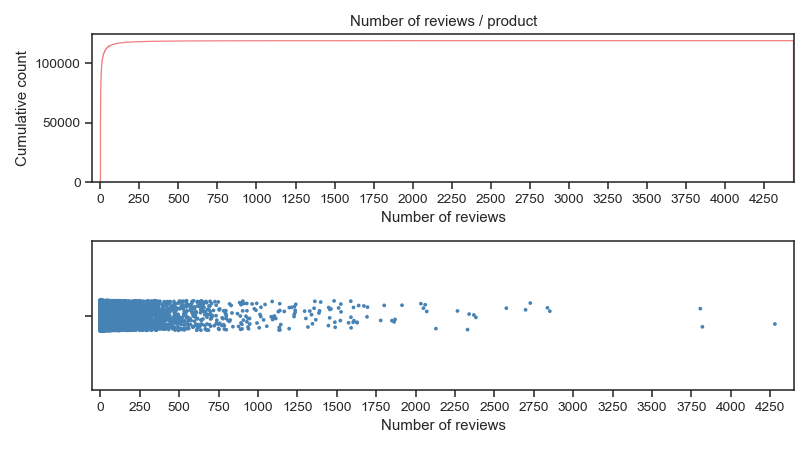

In [23]:
# Draw a count plot and a strip plot
plt.figure(figsize=(9,5))

plt.subplot(2,1,1)
plt.hist(df_count_by_product['number_of_reviews'], bins=4437, cumulative=True, histtype='step', color='lightcoral')
plt.xlim([-50,4440])
plt.xticks(range(0,4400,250))
plt.xlabel('Number of reviews')
plt.ylabel('Cumulative count')
plt.title('Number of reviews / product')

plt.subplot(2,1,2)
sns.stripplot(x='number_of_reviews', data=df_count_by_product, size=3, color='steelblue', jitter=True)
plt.xlim([-50,4400])
plt.xticks(range(0,4400,250))
plt.xlabel('Number of reviews')

plt.tight_layout()
plt.show()

95% of the products have less than 44 reviews. Look closely from 1 to 20.

<IPython.core.display.Javascript object>


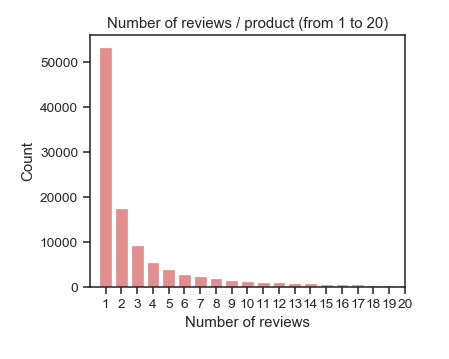

In [24]:
# Draw a strip plot and a count plot
plt.figure(figsize=(5,4))

sns.countplot(x='number_of_reviews', data=df_count_by_product, color='lightcoral')
plt.xlim([-1,19])
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.title('Number of reviews / product (from 1 to 20)')

plt.subplots_adjust(left=0.2, right=0.90, bottom=0.2, top=0.90)
plt.show()

There are many products having a few reviews, but there are also some products having thousands of reviews. Let's collect 10 reviews per product. As a result, lots of products in the data will be removed, and popular products (that have more than 10 reviews) will remain.  

In [25]:
# Extract the products having 10 or more reviews
df_count_more10 = df_count_by_product[df_count_by_product['number_of_reviews'] >= 10]

# Extract reviews which products have 10 or more reviews
df_more10 = df_more30_chara[df_more30_chara['product_id'].isin(df_count_more10.index)]

# Group by 'product_id' to get 10 reviews per product
df_more10_by_product = df_more10.groupby('product_id')

# Get 10 reviews per product
df_10_reviews = pd.DataFrame()
for product, group in df_more10_by_product:
    df_10_reviews = df_10_reviews.append(group.iloc[:10])
    
print("df_10_reviews (first 11 rows):")
df_10_reviews.head(11)

df_10_reviews (first 11 rows):


,product_id,product_title,review_body
38388,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,"Installed quick and easy, the template was wro..."
61551,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,Bought this as a spare in case the design chan...
101017,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,Love it. My cat comes in and out and really l...
101656,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,This worked perfectly for our needs- We put it...
109198,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,"It's easy to instal , big enough for a large c..."
112465,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,Very hard to install by myself
135822,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,I like the clear flexible door.
137926,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,Like this one very much and was easy to instal...
157829,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,works great!! Cat loves it too!!
158431,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,"Great product, but AWFUL instructions. Of cou..."


Let's check that all products have 10 reviews.

In [26]:
# Group by 'product_id' and count the number of reviews for each product
df_count_by_product_10 = df_10_reviews[['product_id','review_body']].groupby('product_id').count()

# Change the column label
df_count_by_product_10.columns = ['number_of_reviews']

# Check the distribution
df_count_by_product_10.describe()

,number_of_reviews
count,20403.0
mean,10.0
std,0.0
min,10.0
25%,10.0
50%,10.0
75%,10.0
max,10.0


Now, all products have 10 reviews.

In [27]:
print('Number of reviews:', len(df_10_reviews))
print('Number of products:', df_10_reviews['product_id'].nunique())

Number of reviews: 204030
Number of products: 20403


### 2.6. Tokenization

Now, there are 20,403 products in the data, and each product has exact 10 reviews. Here, let's merge the reviews in one long review so that we can use it for tokenization.  

In [28]:
# Merging reviews to the same product in one
df_by_product = df_10_reviews[['product_id', 'review_body']].groupby('product_id').sum()

print("df_by_product (first 5 rows):")
df_by_product.head()

df_by_product (first 5 rows):


,review_body
product_id,
70064,"Installed quick and easy, the template was wro..."
119780,My Chihuahua loves getting one of these specia...
202371,love the product but until I feel Stella & Che...
291967,Love love love this undercoat brush... Couldn'...
490904,After using many types of leashes over the yea...


Make a 'product_id'-'product_title' table so that we can use it later.  

In [29]:
# Make a 'product_id'-'product_title' table
id_name = df_10_reviews[['product_id', 'product_title']].groupby('product_id').sum()

print("id_name (first 5 rows):")
id_name.head()

id_name (first 5 rows):


,product_title
product_id,
70064,Perfect Pet Soft Flap Cat Door with Telescopin...
119780,ARK Naturals PRODUCTS for PETS 326066 4-Ounce ...
202371,Stella & Chewy's Freeze Dried Dog Food for Adu...
291967,Premium Deshedding Brush for Dogs and Cats wit...
490904,"Remington Coastal Pet R0206 GRN06 Rope Leash, ..."


To use texts for clustering, the texts have to be divided into words (tokens). Here, let's make tokens from the reviews and save them as a nested list. Each sublist has tokens for one product. 

In [30]:
# Make a nested list from df_by_product['review_body']
reviews_list = list(df_by_product['review_body'])

# Tokenize the reviews
tokens_list = [nltk.word_tokenize(review) for review in reviews_list] 

# How many unique words?
before_word_number = len(set(token for review in tokens_list for token in review))

print('Number of unique tokens:', before_word_number)
print("tokens_list (first 12 tokens of the second product):")
tokens_list[1][:12]

Number of unique tokens: 167145
tokens_list (first 12 tokens of the second product):


['My',
 'Chihuahua',
 'loves',
 'getting',
 'one',
 'of',
 'these',
 'special',
 'treats',
 'every',
 'night',
 '!']

Let's plot the top 30 frequent words.

In [31]:
# Count the number of each word 
words_list_before = [token for review in tokens_list for token in review]
frequency_before = nltk.FreqDist(words_list_before)

# Sort the dictionary
frequency_before_sorted = dict(sorted(frequency_before.items(), key=lambda w: w[1]))

<IPython.core.display.Javascript object>


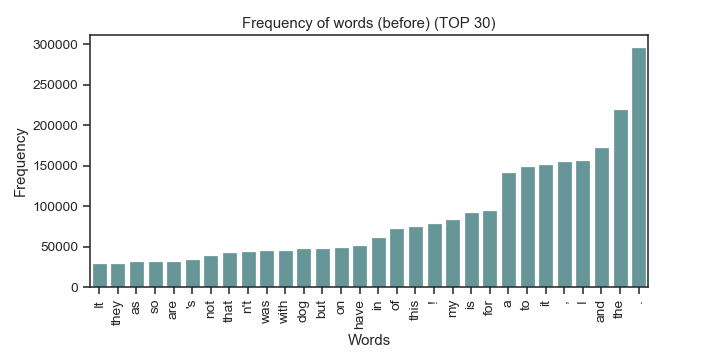

In [32]:
# Create a plot
plt.figure(figsize=(8,4))
sns.barplot(x=list(frequency_before_sorted.keys())[-30:], 
            y=list(frequency_before_sorted.values())[-30:], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (before) (TOP 30)')
plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

There are many words that would not be useful for clustering. Let's clean up the words.  
First, lower the case.

In [33]:
# lower case
tokens_lower_list = [[token.lower() for token in review] for review in tokens_list]

print("tokens_lower_list (first 12 tokens of the second product):")
tokens_lower_list[1][:12]

tokens_lower_list (first 12 tokens of the second product):


['my',
 'chihuahua',
 'loves',
 'getting',
 'one',
 'of',
 'these',
 'special',
 'treats',
 'every',
 'night',
 '!']

In [34]:
# How many unique words?
lower_word_number = len(set(token for review in tokens_lower_list for token in review))

print('Number of tokens removed:', before_word_number - lower_word_number)
print('Current number of unique tokens:', lower_word_number)

Number of tokens removed: 22130
Current number of unique tokens: 145015


### 2.7. Retaining only alphabets 

As you can see above, many punctuation characters are included. Also, numbers can be included frequently. They will not explain a product. Here, we retain only alphabets. 

In [35]:
# Retain alphabetic words
tokens_alpha_list = [[token for token in review if token.isalpha()] for review in tokens_lower_list]

print("tokens_alpha_list (first 12 tokens of the second product):")
tokens_alpha_list[1][:12]

tokens_alpha_list (first 12 tokens of the second product):


['my',
 'chihuahua',
 'loves',
 'getting',
 'one',
 'of',
 'these',
 'special',
 'treats',
 'every',
 'night',
 'they']

In [36]:
# How many unique words?
alph_word_number = len(set(token for review in tokens_alpha_list for token in review))

print('Number of tokens removed:', lower_word_number - alph_word_number)
print('Current number of unique tokens:', alph_word_number)

Number of tokens removed: 68821
Current number of unique tokens: 76194


### 2.8. Removing stop words

Also, stop words have less information about a product, and they are everywhere. Let's remove stop words.

In [37]:
# Remove all stop words
cached_stop_words = stopwords.words('english')
tokens_nostop_list = [[token for token in review if token not in cached_stop_words] 
                      for review in tokens_alpha_list]

print("tokens_nostop_list (first 12 tokens of the second product):")
tokens_nostop_list[1][:12]

tokens_nostop_list (first 12 tokens of the second product):


['chihuahua',
 'loves',
 'getting',
 'one',
 'special',
 'treats',
 'every',
 'night',
 'convenient',
 'use',
 'lot',
 'trouble']

In [38]:
# How many unique words?
nostop_word_number = len(set(token for review in tokens_nostop_list for token in review))

print('Number of tokens removed:', alph_word_number - nostop_word_number)
print('Current number of unique tokens:', nostop_word_number)

Number of tokens removed: 147
Current number of unique tokens: 76047


### 2.9. Stemming and lemmatization

English words change the form depending on a context. To reduce a word to its word stem (or root), stemming and lemmatization are used. 

Stemming:

In [39]:
# Stemming by Snowball stemmer
snowball = SnowballStemmer(language='english')
tokens_stem_list = [[snowball.stem(token) for token in review] for review in tokens_nostop_list]

print("tokens_stem_list (first 12 tokens of the second product):")
tokens_stem_list[1][:12]

tokens_stem_list (first 12 tokens of the second product):


['chihuahua',
 'love',
 'get',
 'one',
 'special',
 'treat',
 'everi',
 'night',
 'conveni',
 'use',
 'lot',
 'troubl']

In [40]:
# How many unique words?
stem_word_number = len(set(token for review in tokens_stem_list for token in review))

print('Number of tokens removed:', nostop_word_number - stem_word_number)
print('Current number of unique tokens:', stem_word_number)

Number of tokens removed: 15217
Current number of unique tokens: 60830


Lemmatization:

In [41]:
# Lemmatization to tokens_stem_list
lem = nltk.WordNetLemmatizer()
tokens_lem_list = [[lem.lemmatize(token) for token in review] for review in tokens_stem_list]

print("tokens_lem_list (first 12 tokens of the second product):")
tokens_lem_list[1][:12]

tokens_lem_list (first 12 tokens of the second product):


['chihuahua',
 'love',
 'get',
 'one',
 'special',
 'treat',
 'everi',
 'night',
 'conveni',
 'use',
 'lot',
 'troubl']

In [42]:
# How many unique words?
stem_lem_word_number = len(set(token for review in tokens_lem_list for token in review))

print('Number of tokens removed:', stem_word_number - stem_lem_word_number)
print('Current number of unique tokens:', stem_lem_word_number)

Number of tokens removed: 184
Current number of unique tokens: 60646


### 2.10. Retaining only nouns

To categorize products, these two questions are important; what animal use it? and what is it for? To answer them, nouns  are essential, and others are not so much. Here, let's retain only nouns by using part-of-speech tagging technique.

POS tagging:

In [43]:
# Show POS
tag_list = [nltk.pos_tag(review) for review in tokens_stem_list]

print("tag_list (first 12 tokens of the second product):")
tag_list[1][:12]

tag_list (first 12 tokens of the second product):


[('chihuahua', 'NN'),
 ('love', 'VB'),
 ('get', 'VB'),
 ('one', 'CD'),
 ('special', 'JJ'),
 ('treat', 'NN'),
 ('everi', 'NNS'),
 ('night', 'NN'),
 ('conveni', 'NN'),
 ('use', 'NN'),
 ('lot', 'NN'),
 ('troubl', 'NNS')]

Retain only nouns:

In [44]:
# Retain only nouns
token_noun_list = [[token[0] for token in review if token[1] == 
                    ('NN' or 'NNS' or 'NNP' or 'NNPS')] for review in tag_list]

print("token_noun_list (first 12 tokens of the second product):")
token_noun_list[1][:12]

token_noun_list (first 12 tokens of the second product):


['chihuahua',
 'treat',
 'night',
 'conveni',
 'use',
 'lot',
 'size',
 'treat',
 'way',
 'dog',
 'chihuahua',
 'everi']

In [45]:
# How many unique words?
noun_word_number = len(set(token for review in token_noun_list for token in review))

print('Number of tokens removed:', stem_word_number - noun_word_number)
print('Current number of unique tokens:', noun_word_number)

Number of tokens removed: 19613
Current number of unique tokens: 41217


### 2.11. Remove insignificant words

Words appearing only a few in the total products are not useful to know the relationship with other products. Let's removing words appearing in less than 5 products. Also, there would be very frequent but not useful words for clustering. Let's remove them too. 

Remove words appearing in less than 5 products:

In [46]:
# Count the frequency of each word among products
for_count = []
for review in token_noun_list:
    for_count.extend(set(review))
    
word_frequency = nltk.FreqDist(for_count)

# Sort the dictionary by count
word_frequency_sorted = dict(sorted(word_frequency.items(), key=lambda w: w[1]))

# Collect frequent words (more than 5 times)
freq_words = [k for k, v in word_frequency_sorted.items() if v > 5]

# Remove words appearing less than 5 times from the token list
token_more5_list = [[token for token in review if token in freq_words] for review in  token_noun_list]

In [47]:
print("token_more5_list (first 12 tokens of the second product):")
token_more5_list[1][:12]

token_more5_list (first 12 tokens of the second product):


['chihuahua',
 'treat',
 'night',
 'conveni',
 'use',
 'lot',
 'size',
 'treat',
 'way',
 'dog',
 'chihuahua',
 'everi']

Remove very frequent but not useful words:

Let's check the top 200 frequent words.

<IPython.core.display.Javascript object>


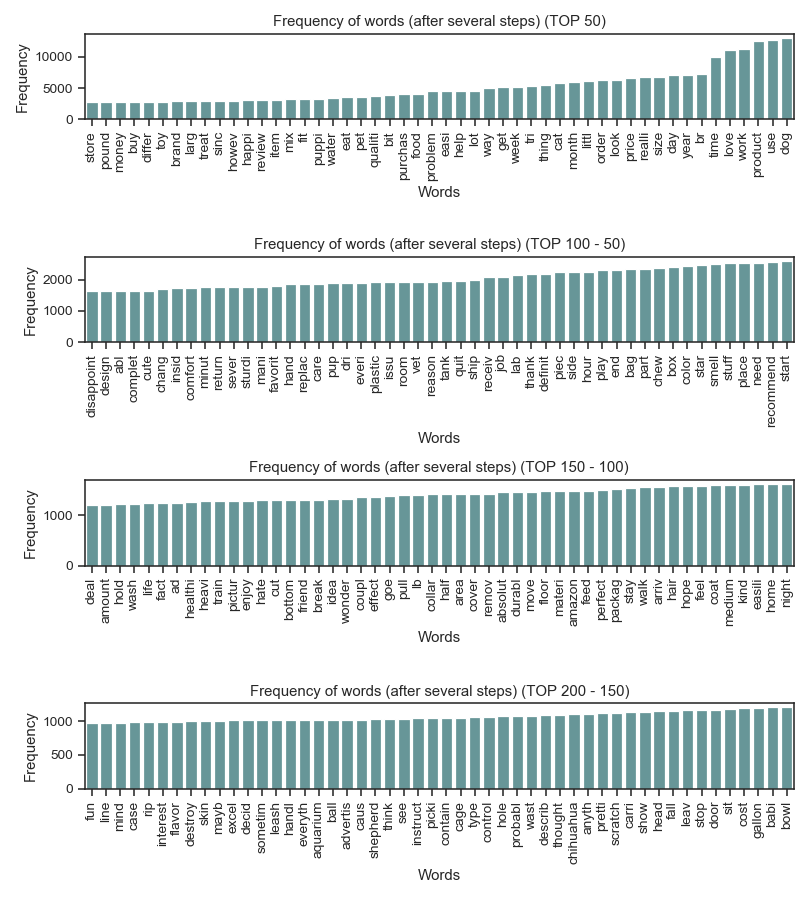

In [48]:
# Create a plot
plt.figure(figsize=(9,10))
plt.subplot(4,1,1)
sns.barplot(x=list(word_frequency_sorted.keys())[-50:], y=list(word_frequency_sorted.values())[-50:], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after several steps) (TOP 50)')

plt.subplot(4,1,2)
sns.barplot(x=list(word_frequency_sorted.keys())[-100:-50], y=list(word_frequency_sorted.values())[-100:-50], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after several steps) (TOP 100 - 50)')

plt.subplot(4,1,3)
sns.barplot(x=list(word_frequency_sorted.keys())[-150:-100], y=list(word_frequency_sorted.values())[-150:-100], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after several steps) (TOP 150 - 100)')

plt.subplot(4,1,4)
sns.barplot(x=list(word_frequency_sorted.keys())[-200:-150], y=list(word_frequency_sorted.values())[-200:-150], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after several steps) (TOP 200 - 150)')

plt.tight_layout()
plt.show()

Some words on this chart would not be useful.  I'm removing the words by hand.

In [49]:
# Pick up words that would not be useful to categolize products from TOP 200 words
removed_words = ['use', 'product', 'work', 'love', 'time', 'br', 'year', 'day', 'size', 'realli', 'price', 'look', 
                 'order', 'littl', 'month', 'thing', 'tri', 'week', 'get', 'way', 'lot', 'help', 'easi', 'problem', 
                 'purchas', 'bit', 'qualiti', 'pet', 'item', 'review', 'happi', 'howev', 'larg', 'brand', 'differ', 
                 'buy', 'money', 'pound', 'store', 'start', 'recommend', 'need', 'place', 'stuff', 'star', 'part', 'end', 
                 'hour', 'piec', 'definit', 'thank', 'job', 'receiv', 'ship', 'reason', 'everi', 'replac', 'favorit', 
                 'mani', 'return', 'minut', 'chang', 'cute', 'complet', 'abl', 'disappoint', 'easili', 'kind', 
                 'medium', 'feel', 'hope', 'arriv', 'packag', 'perfect', 'amazon', 'move', 'half', 'lb', 'goe', 
                 'coupl', 'wonder', 'idea', 'friend', 'hate', 'pictur', 'heavi', 'ad', 'fact', 'life', 'hold', 
                 'amount', 'deal', 'babi', 'cost', 'stop', 'leav', 'show', 'pretti', 'anyth', 'thought', 'describ',
                 'probabl', 'type', 'see', 'think', 'caus', 'advertis', 'everyth', 'sometim', 'decid', 'excel',
                 'mayb', 'destroy', 'interest', 'rip', 'case', 'mind']
 
# Remove them from token_more5_list
token_removed_list = [[token for token in review if token not in removed_words] for review in  token_more5_list]

Show the new frequent word plot.

In [50]:
# Count the number of each word 
words_list_after = [token for review in token_removed_list for token in review]
frequency_after = nltk.FreqDist(words_list_after)

# Sort the dictionary
frequency_after_sorted = dict(sorted(frequency_after.items(), key=lambda w: w[1]))

<IPython.core.display.Javascript object>


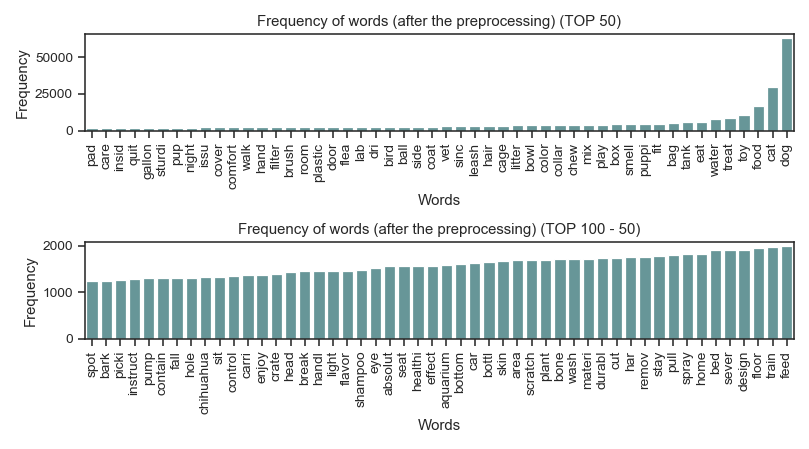

In [51]:
# Create a plot
plt.figure(figsize=(9,5))
plt.subplot(2,1,1)
sns.barplot(x=list(frequency_after_sorted.keys())[-50:], y=list(frequency_after_sorted.values())[-50:], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after the preprocessing) (TOP 50)')

plt.subplot(2,1,2)
sns.barplot(x=list(frequency_after_sorted.keys())[-100:-50], y=list(frequency_after_sorted.values())[-100:-50],
            color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after the preprocessing) (TOP 100 - 50)')

plt.tight_layout()
plt.show()

Now, most of the frequent words look important.   
We have removed many words, and it might have made some products have a empty token list. Let's check the situation.

In [52]:
# Check the number of tokens per product
number_token_list = [len(tokens) for tokens in token_removed_list]

# Show the minimum and maximum
print('Minimum number of tokens per product:', min(number_token_list))
print('Maximum number of tokens per product:', max(number_token_list))

Minimum number of tokens per product: 5
Maximum number of tokens per product: 126


<IPython.core.display.Javascript object>


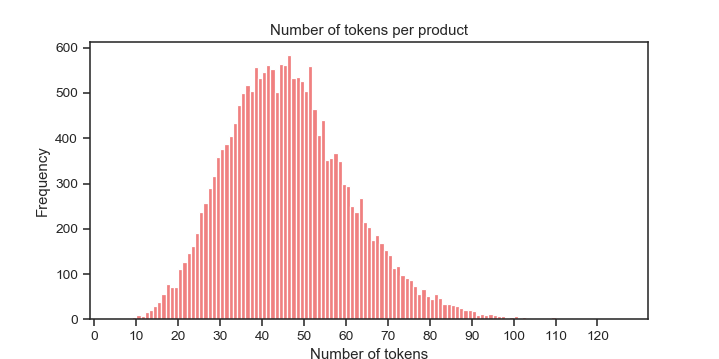

In [53]:
# Draw a bar plot
plt.figure(figsize=(8,4))

plt.hist(number_token_list, bins=121, color='lightcoral')
plt.xticks(range(0,130,10))
plt.yticks(range(0,650,100))
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.title('Number of tokens per product') 

plt.show()

There is no empty token product. The minimum is 5 tokens.

In [54]:
# How many unique words?
important_word_number = len(set(token for review in token_removed_list for token in review))

print('Number of products:', len(number_token_list))
print('Current number of unique tokens:', important_word_number)

Number of products: 20403
Current number of unique tokens: 6937


## 3. Exploratory Data Analysis

Now, our tokens are ready for clustering, but first let's take a look at the content. I already stated two important questions to categorize these products; what animal use it? and what is it for? Here, let's take a brief look at them.

3.1. The number of products relating to each **animal kind**  
3.2. The number of products relating to each **application type**  
3.3. The rough relationship between an **animal kind and application type**  
3.4. Dividing the data according to animal kinds

### 3.1. The number of products relating to each animal kind

I believe some of the most popular pets are dogs, cats, birds, fish, and rabbits. Let's count the rough numbers of products relating to each of them. If a product has 'dog' as the token, the product could be related to dogs. Let's use this way here.

In [55]:
# Define a function returning the number of products having a specific word as a token
def count_word(word):
    count = 0
    for product in token_removed_list:
        if word in product:
            count += 1
    return count

Number of products relating to each animal:

In [56]:
# Count products having 'dog', 'puppi' or 'doggi' as a token
count_dog = count_word('dog' or 'puppi' or 'doggi' or 'pup')
print('Dog:', count_dog)

# Count products having 'cat', 'kitti', 'kitt' or 'kitten' as a token
count_cat = count_word('cat' or 'kitti' or 'kitt' or 'kitten')
print('Cat:', count_cat)

# Count products having 'bird' or 'chick' as a token
count_bird = count_word('bird' or 'chick')
print('Bird:', count_bird)

# Count products having 'fish' as a token
count_fish = count_word('fish')
print('Fish:', count_fish)

# Count products having 'rabbit' or 'bunni' as a token
count_rabbit = count_word('rabbit' or 'bunni')
print('Rabbit:', count_rabbit)

Dog: 13106
Cat: 5875
Bird: 937
Fish: 722
Rabbit: 502


<IPython.core.display.Javascript object>


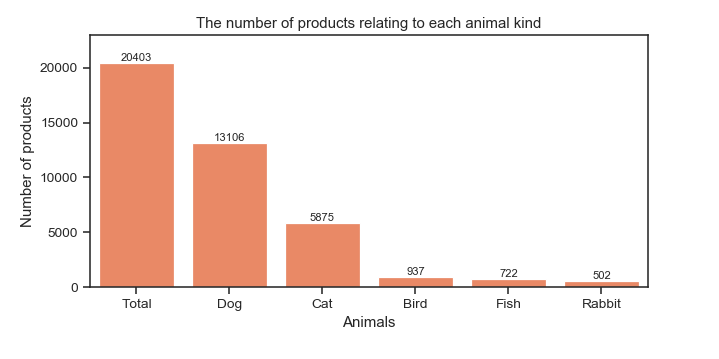

In [57]:
# Draw a bar plot
plt.figure(figsize=(8,4))

X = ['Total', 'Dog', 'Cat', 'Bird', 'Fish', 'Rabbit']
Y = [len(token_removed_list), count_dog, count_cat, count_bird, count_fish, count_rabbit]

p = sns.barplot(x=X, y=Y, color='coral')
plt.xlabel('Animals')
plt.ylabel('Number of products')
plt.ylim([0, 23000])
plt.title('The number of products relating to each animal kind')

for x, y in zip([0, 1, 2, 3, 4, 5], Y):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=9)

plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

The main animal categories are Dog and Cat. Especially, 64% of the products are related to dogs.

### 3.2. The number of products relating to each application type

What is the application categories of these products? I can say these are popular; food, treats, toys, toilet, cages, clothes, and collars.

Number of products relating to each application:

In [58]:
# Count products having 'food', 'dri' or 'wet' as a token
count_food = count_word('food' or 'dri' or 'wet')
print('Food:', count_food)

# Count products having 'treat', 'snack', or 'cooki' as a token
count_treat = count_word('treat' or 'snack' or 'cooki')
print('Treat:', count_treat)

# Count products having 'toy', 'tunnel', 'ball', or 'rope' as a token
count_toy = count_word('toy' or 'tunnel' or 'ball' or 'rope')
print('Toy:', count_toy)

# Count products having 'litter', or 'pad' as a token
count_toilet = count_word('litter' or 'pad')
print('Toilet:', count_toilet)

# Count products having 'cage', 'crate', 'carrier', or 'kennel' as a token
count_cage = count_word('cage' or 'crate' or 'carrier' or 'kennel')
print('Cage:', count_cage)

# Count products having 'shirt', 'coat', 'sweater', or 'costum' as a token
count_clothes = count_word('shirt' or 'coat' or 'sweater' or 'costum')
print('Clothes:', count_clothes)

# Count products having 'collar', or 'leash' as a token
count_collar = count_word('collar' or 'leash')
print('Collar&Leash:', count_collar)

Food: 4034
Treat: 2897
Toy: 2803
Toilet: 873
Cage: 1050
Clothes: 155
Collar&Leash: 1410


<IPython.core.display.Javascript object>


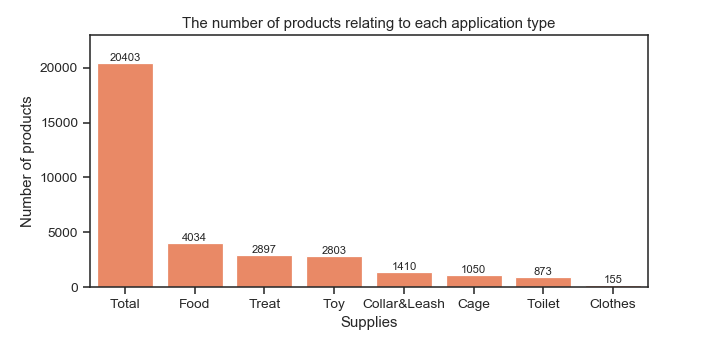

In [59]:
# Draw a bar plot
plt.figure(figsize=(8,4))

X2 = ['Total', 'Food', 'Treat', 'Toy', 'Collar&Leash', 'Cage', 'Toilet', 'Clothes']
Y2 = [len(token_removed_list), count_food, count_treat, count_toy, count_collar, count_cage, count_toilet, count_clothes]

sns.barplot(x=X2, y=Y2, color='coral')
plt.xlabel('Supplies')
plt.ylabel('Number of products')
plt.ylim([0, 23000])
plt.title('The number of products relating to each application type')

for x, y in zip([0, 1, 2, 3, 4, 5, 6, 7], Y2):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=9)

plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

The top 3 categories are Food, Treat, and Toy, but the products are relatively spread.

### 3.3. The rough relationship between an animal kind and application type

I pick up Dog and Cat as animal kind categories, and Toy and Food as application type categories. Check the relationships between them.

In [60]:
# Define a function making coordinates. word1 and word2 can accept a list.
def make_coordinate(list_name, word1, word2, num):
    for i in range(len(token_removed_list)):
        product = token_removed_list[i]
        for token in product:
            if token in word1:
                list_name[i][num] += 1
                break
        for token in product:
            if token in word2:
                list_name[i][num] += 2
                break
    return list_name

In [61]:
# Make coorfinates showing the presence of words; dog and/or cat,and toy and/or food
# [1, 0] means the product has 'dog' and doesn't have 'cat', 'toy', or 'food' as the tokens
# [3, 2] means the product has 'dog', 'cat', and 'food' as the tokens

# Make an initial list
animal_supply = [[0, 0] for i in range(len(token_removed_list))]

# Make coorfinates
animal_supply = make_coordinate(animal_supply, ['dog','puppi','doggi','pup'], ['cat','kitti','kitt','kitten'] , 0)
animal_supply = make_coordinate(animal_supply, ['toy','tunnel','ball','rope'], ['food','dri','wet'], 1)
animal_supply[:10]

[[2, 0],
 [1, 0],
 [1, 2],
 [1, 0],
 [1, 1],
 [3, 2],
 [0, 0],
 [0, 0],
 [1, 0],
 [1, 2]]

<IPython.core.display.Javascript object>


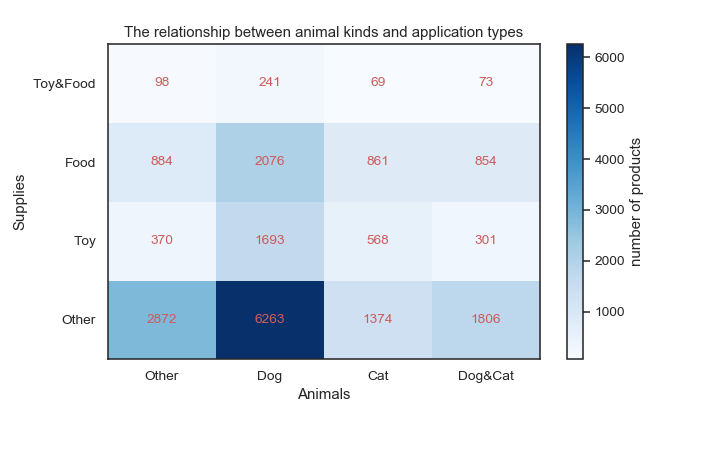

In [62]:
# Make an initial list to draw a pseudocolor plot
mesh_list = [[0,0,0,0], [0,0,0,0],[0,0,0,0],[0,0,0,0]]

# Count the number of products fitting each compartment and make the numpy array
for product in animal_supply:
    mesh_list[product[1]][product[0]] += 1
mesh_arr = np.array(mesh_list)

# Make mesh
u = np.linspace(-1, 1, 5)
v = np.linspace(-1, 1, 5)
X,Y = np.meshgrid(u, v)

# Draw a pseudocolor plot
plt.figure(figsize=(8,5))
plt.pcolor(mesh_arr, cmap='Blues')
pp = plt.colorbar()
pp.set_label('number of products')
plt.xticks(ticks=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], labels=['','Other', '', 'Dog', '', 'Cat', '', 'Dog&Cat', ''])
plt.yticks(ticks=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], labels=['','Other', '', 'Toy', '', 'Food', '', 'Toy&Food', ''])
plt.tick_params(bottom=False, left=False)
plt.xlabel('Animals')
plt.ylabel('Supplies')
plt.title('The relationship between animal kinds and application types')

for y in [0.5, 1.5, 2.5, 3.5]:
    for x in [0.5, 1.5, 2.5, 3.5]: 
        plt.text(x, y, mesh_list[int(y-0.5)][int(x-0.5)], ha='center', va='center', fontsize=11, color='indianred')

plt.subplots_adjust(left=0.15, right=0.90, bottom=0.2, top=0.90)
plt.show()

Food and toys for dogs are the largest two categories on the chart, but many products are in Other. I will categorize them more precisely in the clustering part of this project. 

### 3.4. Dividing the data according to animal kinds

There are 20,403 products in the data, and it's big. Let's divide them into three sets; dog, cat, and other.

In [63]:
# Divid the data into three 
dog_index_list = []
dog_token_list = []

cat_index_list = []
cat_token_list = []

other_index_list = []
other_token_list = []

for i, product in enumerate(token_removed_list):
    count_dog = product.count('dog') + product.count('puppi') + product.count('doggi') + product.count('pup')
    count_cat = product.count('cat') + product.count('kitti') + product.count('kitt') + product.count('kitten')
    count_bird = product.count('bird') + product.count('chick')
    count_fish = product.count('fish')
    count_rabbit = product.count('rabbit') + product.count('bunni')
    
    if count_dog > max([count_cat, count_bird, count_fish, count_rabbit]):
        dog_index_list.append(i)
        dog_token_list.append(product)
    
    elif count_cat > max([count_bird, count_fish, count_rabbit]):
        cat_index_list.append(i)
        cat_token_list.append(product)

    else:
        other_index_list.append(i)
        other_token_list.append(product)

Divided token lists:

In [64]:
# Show each token list
print("dog_token_list (first 5 tokens of the fist product):", dog_token_list[0][:5])

print("cat_token_list (first 5 tokens of the fist product):", cat_token_list[0][:5])

print("other_token_list (first 5 tokens of the fist product):", other_token_list[0][:5])

dog_token_list (first 5 tokens of the fist product): ['chihuahua', 'treat', 'night', 'conveni', 'treat']
cat_token_list (first 5 tokens of the fist product): ['templat', 'wont', 'door', 'pick', 'litter']
other_token_list (first 5 tokens of the fist product): ['lint', 'roller', 'hair', 'cloth', 'pick']


Number of the products in each dataset:

In [65]:
# Number of the products in each dataset
print('dog :', len(dog_index_list))
print('cat :', len(cat_index_list))
print('other :', len(other_index_list))

dog : 11916
cat : 4099
other : 4388


Number of the unique tokens in each dataset:

In [66]:
# Check the number of unique words
for i in range(3):
    token_lists = [dog_token_list, cat_token_list, other_token_list]
    animals = ['dog', 'cat', 'other']
    
    print(animals[i], ':', len(set(token for review in token_lists[i] for token in review)))

dog : 6682
cat : 6001
other : 5914


Summary statistics of the number of tokens:

<IPython.core.display.Javascript object>


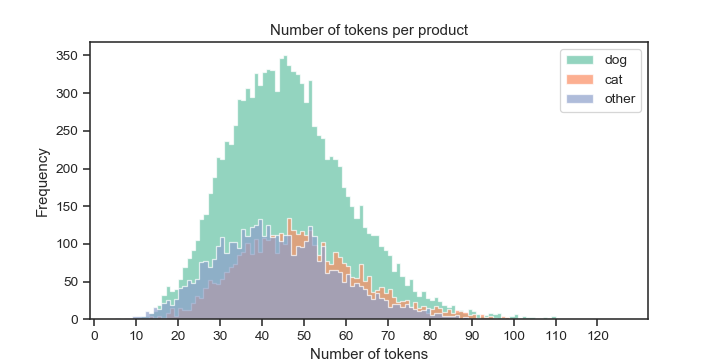

Summary statistics of the number of tokens for each animal category:


,min,25%,50%,75%,90%,max,mean,std
category,,,,,,,,
dog,7,36.0,45.0,55.0,66.0,126,46.0,14.8
cat,9,38.0,47.0,58.0,69.0,120,48.7,15.1
other,5,32.0,42.0,52.0,63.0,98,43.1,14.7


In [68]:
# Make the summary statistics of the number of tokens for each animal category
df_token_stats = pd.DataFrame(columns=['category', 'min', '25%', '50%', '75%', '90%', 'max', 'mean', 'std'])

plt.figure(figsize=(8,4))

for i in range(3):
    token_lists = [dog_token_list, cat_token_list, other_token_list]
    animals = ['dog', 'cat', 'other']
    
    # Check the number of tokens per product
    number_of_tokens = [len(tokens) for tokens in token_lists[i]]
    
    # Draw a bar plot
    plt.hist(number_of_tokens, bins=max(number_of_tokens)-min(number_of_tokens), 
             color=cmap1(i), label=animals[i], histtype='stepfilled', alpha=0.7)
    
    
    # Make a temporary dataframe showing each numbers
    df_temp = pd.DataFrame([[animals[i],
                             min(number_of_tokens), 
                             np.percentile(number_of_tokens, 25), 
                             np.percentile(number_of_tokens, 50), 
                             np.percentile(number_of_tokens, 75), 
                             np.percentile(number_of_tokens, 90), 
                             max(number_of_tokens),
                             round(np.mean(number_of_tokens), 1),
                             round(np.std(number_of_tokens), 1)]], 
                             columns=df_token_stats.columns)
    df_token_stats = df_token_stats.append(df_temp) 

plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.xticks(range(0,130,10))
plt.title('Number of tokens per product') 
plt.legend()
plt.show()

print('Summary statistics of the number of tokens for each animal category:')
df_token_stats.set_index('category')

id-title tables:  
Our goal of this project is to label each product in these tables. The titles will help us decide the category name. 

In [69]:
# Show each id-title list
df_dog_id_name = id_name.iloc[dog_index_list]
print('dog products:')
print(df_dog_id_name.head())
print('--------------------------------------------------------------') 

df_cat_id_name = id_name.iloc[cat_index_list]
print('cat products:')
print(df_cat_id_name.head())
print('--------------------------------------------------------------') 

df_other_id_name = id_name.iloc[other_index_list]
print('other products:')
print(df_other_id_name.head())

dog products:
                                                product_title
product_id                                                   
119780      ARK Naturals PRODUCTS for PETS 326066 4-Ounce ...
202371      Stella & Chewy's Freeze Dried Dog Food for Adu...
291967      Premium Deshedding Brush for Dogs and Cats wit...
490904      Remington Coastal Pet R0206 GRN06 Rope Leash, ...
798322      Pet Dog Puppy Nonslip Canvas Sport Shoes Sneak...
--------------------------------------------------------------
cat products:
                                                product_title
product_id                                                   
70064       Perfect Pet Soft Flap Cat Door with Telescopin...
593896      Pet Food Can Covers Lids Set of 3Pet Food Can ...
919291      Basis Pet Made in the USA Low Profile Stainles...
944764      Alfie Pet by Petoga Couture - Vea 2.0 Slow-Eat...
1124833     Petmate Hooded Cat Litter PanPetmate Hooded Ca...
-----------------------------------------

Save the token lists and id-title tables:  
We save the token lists and id-title tables to use on another jupyter notebook.

In [70]:
# Save the list and dataframe as a csv file

# for dog
# with open('dog_token_list.csv', 'w', encoding='UTF-8') as f:
#     writer = csv.writer(f, lineterminator='\n')
#     writer.writerows(dog_token_list)

# df_dog_id_name.to_csv('df_dog_id_name.csv')

print('< Dog category >')
print('dog_token_list:', 'dog_token_list.csv')
print('df_dog_id_name:', 'df_dog_id_name.csv')
print('')

# for cat
# with open('cat_token_list.csv', 'w', encoding='UTF-8') as f:
#     writer = csv.writer(f, lineterminator='\n')
#     writer.writerows(cat_token_list)

# df_cat_id_name.to_csv('df_cat_id_name.csv')

print('< Cat category >')
print('cat_token_list:', 'cat_token_list.csv')
print('df_cat_id_name:', 'df_cat_id_name.csv')
print('')

# for others
# with open('other_token_list.csv', 'w', encoding='UTF-8') as f:
#     writer = csv.writer(f, lineterminator='\n')
#     writer.writerows(other_token_list)

# df_other_id_name.to_csv('df_other_id_name.csv')

print('< Other category >')
print('other_token_list:', 'other_token_list.csv')
print('df_other_id_name:', 'df_other_id_name.csv')

< Dog category >
dog_token_list: dog_token_list.csv
df_dog_id_name: df_dog_id_name.csv

< Cat category >
cat_token_list: cat_token_list.csv
df_cat_id_name: df_cat_id_name.csv

< Other category >
other_token_list: other_token_list.csv
df_other_id_name: df_other_id_name.csv


The clustering part is in a different jupyter notebook. See the jupyter notebook; CapstoneProject1_codes_clustering. 